Transformer 모델 사용
<br> IMDb 영화 리뷰 데이터를 분석 -> 긍/부정 분류

In [1]:
import tensorflow as tf
from tensorflow import keras

2024-08-07 13:34:43.894450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 13:34:43.914203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 13:34:43.920111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-07 13:34:43.936239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-07 13:34:45.297963: W tensorflow/compiler/tf2

In [40]:
vocab_size = 20000  # 상위 20,000개의 단어만 사용
maxlen = 200  # 각 영화평의 길이를 200으로 맞춤

(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_test), "Test sequences")

x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

# IMDb 데이터셋 로드,  훈련 데이터와 테스트 데이터 세팅
# pad_sequences : 모든 리뷰의 길이를 동일하게



25000 Training sequences
25000 Test sequences


In [41]:
#################
# 인코더 블록 정의
#################

from tensorflow.keras import layers

class EncoderBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):

        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


# MultiHeadAttention: 멀티헤드 어텐션 레이어
# ffn: 완전연결층(Feed Forward Network)
# LayerNormalization: 레이어 정규화
# Dropout: 드롭아웃 -> 과적합 방지

In [42]:
# 토큰 및 위치 임베딩 정의
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):

        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Embedding: 단어 -> 임베딩 벡터로 변환
# pos_emb: 각 위치에 대한 임베딩 추가

In [43]:
# 모델 설계

embed_dim = 32  # 각 토큰의 임베딩 벡터 크기
num_heads = 2  # 어텐션 헤드의 수
ff_dim = 32  # 완전연결층의 노드 수

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = EncoderBlock(embed_dim, num_heads, ff_dim)(x, training=True)
x = EncoderBlock(embed_dim, num_heads, ff_dim)(x, training=True)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)


# TokenAndPositionEmbedding 레이어 사용 -> 입력 시퀀스 임베딩
# 두 개의 EncoderBlock -> 입력 시퀀스를 처리
# GlobalAveragePooling1D: 시퀀스의 평균
# Dense 레이어 + Dropout -> 모델 출력 생성


In [44]:
model = keras.Model(inputs=inputs, outputs=outputs)

In [45]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_2  │ (None, 200, 512)       │    10,342,400 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_8 (EncoderBlock)  │ (None, 200, 512)       │     6,336,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 20)             │        10,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │            42 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,689,246 (63.66 MB)

 Trainable params: 16,689,246 (63.66 MB)

 Non-trainable params: 0 (0.00 B)

모델 컴파일 및 **학습**

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [47]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
checkpoint_filepath = './temp/checkpoint_en.weights.h5'
mc = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min',
                     save_weights_only=True, save_best_only=True)


# EarlyStopping:  학습 조기 종료
# ModelCheckpoint: 모델 가중치 저장


In [48]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [49]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [50]:
history = model.fit(
    x_train, y_train_one_hot, batch_size=24, epochs=100, validation_split=0.1, callbacks=[es, mc]
)

Epoch 1/100


2024-08-07 13:31:15.934398: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_39', 4 bytes spill stores, 4 bytes spill loads

2024-08-07 13:31:18.892965: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 24 bytes spill stores, 24 bytes spill loads

2024-08-07 13:31:19.233683: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_39', 568 bytes spill stores, 380 bytes spill loads

2024-08-07 13:31:19.347226: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_40', 564 bytes spill stores, 556 bytes spill loads

2024-08-07 13:31:20.098303: I external/local_xla/xla/stream_executo

937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4986 - loss: 0.6966

2024-08-07 13:32:26.935064: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 20 bytes spill stores, 20 bytes spill loads

2024-08-07 13:32:27.197885: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 24 bytes spill stores, 24 bytes spill loads

2024-08-07 13:32:27.367548: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 24 bytes spill stores, 24 bytes spill loads

2024-08-07 13:32:29.401362: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 24 bytes spill stores, 24 bytes spill loads

2024-08-07 13:32:37.120951: I external/local_xla/xla/stream_executor/cud

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4986 - loss: 0.6966

2024-08-07 13:32:49.044762: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 4 bytes spill stores, 4 bytes spill loads

2024-08-07 13:32:49.220053: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9', 84 bytes spill stores, 84 bytes spill loads

2024-08-07 13:32:49.231760: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 200 bytes spill stores, 168 bytes spill loads

2024-08-07 13:32:49.635825: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8', 16 bytes spill stores, 16 bytes spill loads

2024-08-07 13:32:49.640220: I external/local_xla/xla/stream_executor/cud

938/938 ━━━━━━━━━━━━━━━━━━━━ 110s 81ms/step - accuracy: 0.4986 - loss: 0.6966 - val_accuracy: 0.4876 - val_loss: 0.6932
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.4995 - loss: 0.6932 - val_accuracy: 0.4876 - val_loss: 0.6934
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.5023 - loss: 0.6932 - val_accuracy: 0.4876 - val_loss: 0.6932
Epoch 4/100
349/938 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.4961 - loss: 0.6932

406/938 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.4964 - loss: 0.6932

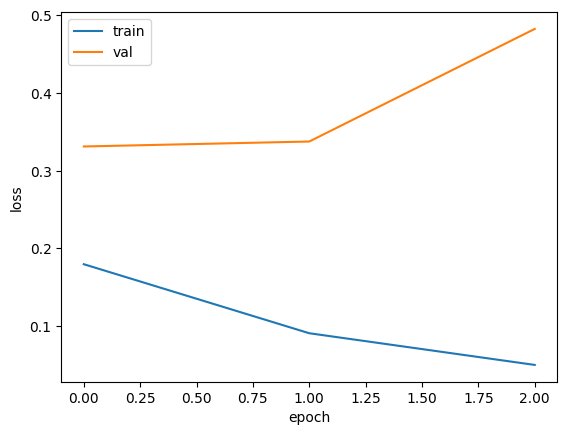

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)

# 학습된 모델의 가중치 호출(from 파일) .... 검증 손실이 가장 낮은 지점에서 가중치가 저장된 파일
# ->  저장된 가중치를 사용하여 예측 수행 or 추가 학습



In [ ]:
test_loss, test_acc = model.evaluate(x_test,y_test_one_hot)

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8661 - loss: 0.3471


In [ ]:
preds = model.predict(x_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step


In [ ]:
import numpy as np
labels=[0,1]
preds1 = [labels[np.argmax(probs)] for probs in preds]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds1))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86     12500
           1       0.83      0.92      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.87      0.86      0.86     25000
weighted avg       0.87      0.86      0.86     25000

